In [1]:
%matplotlib widget

from utils import *

set_cache_dir('pickles/slides5')

import logging
import numpy as np
import matplotlib.pyplot as plt
import climada
import cartopy

ERROR 1: PROJ: proj_create_from_database: Open of /home/arthur/miniforge3/envs/climada_env/share/proj failed


# Modelling Exposures with Climada

<img src="litpop1.png" />

## Challenges of exposure data

Exposure data can come in different forms:
1. It may be known exactly: for instance, an insurer might have data of insured assets in a given region of the world
2. Often it is not known exactly. In that case, it must be estimated from alternate sources of data.

## LitPop

LitPop is a methodology aimed at combining population count data and nightlight data with asset value at the national level to produce disaggregated asset value at higher spatial resolution. 

Let $I_{tot}$ be the national-level asset value. Assume that the country's spatial region is gridded into $N$ pixels. Then the asset value assigned to a given pixel $k$ is,

\begin{equation}
    I_k = I_{tot} \cdot \frac{w_k}{\sum_{k'=1}^N w_k'}, \quad k=1,\ldots,N.
\end{equation}

where the weights are defined by,
\begin{equation}
    w_k = (\text{NL}_k + \delta)^n \text{Pop}_k^m,
\end{equation}
with,
1. $\text{NL}_k$ the measured amount of night light for pixel k
2. $\text{Pop}_k$ the population count for pixe k

Question: with the formula above, what is the value of the sum of pixel-wise asset values? That is, $\sum_{k=1}^N I_k$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
np.random.seed(1712)

## Usage in Climada: quick example

In [3]:
import warnings # To hide the warnings
warnings.filterwarnings('ignore')

import logging
lger = logging.getLogger('climada')
lger.setLevel('ERROR')

<div class="alert alert-block alert-danger">
<p>According to the CLIMADA documentation, we need to download a file containing the population count and add it to the climda/data directory. I have already downloaded this file on the Jupyter hub set up for this course, but you need to copy-paste it to your climada/data directory.</p>

<p>
The file's name is: gpw_v4_population_count_rev11_2020_30_sec.tif
</p>
</div>

Here we obtain exposure data for Puerto Rico. The parameter `res_arcsec` allows to specify the resolution. A higher resolution will provide more accurate results but will be more computationally expensive.

```python
from climada.entity.exposures import LitPop

exposure = LitPop.from_countries(['Puerto Rico', ], res_arcsec = 120)
exposure.plot_scatter(pop_name=False);
```

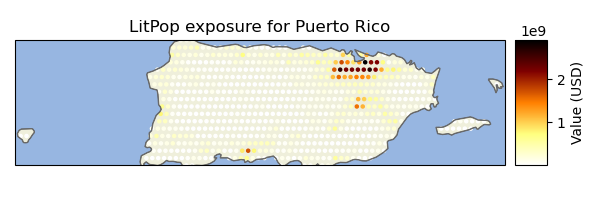

In [19]:
from climada.entity.exposures import LitPop

try:
    exposure = load_from_cache('exposure')
except FileNotFoundError:
    exposure = LitPop.from_countries(['Puerto Rico', ], res_arcsec = 120)
    save_to_cache('exposure', exposure)

from utils import get_projection

    
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(projection=get_projection())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
exposure.plot_scatter(axis=ax, pop_name=False, cmap='afmhot_r', s=5)
ax.set_title('LitPop exposure for Puerto Rico')
fig.tight_layout()

## The Exposure class

In Climada, exposures are instances of the class `Exposure`. In particular, this class has an attribute `gdf` that stores valueable information as a pandas dataframe.

```python
exposure.gdf.head()
```

In [5]:
exposure.gdf.head()

,value,latitude,longitude,geometry,region_id,impf_
0,5.807070e+01,18.083333,-67.916667,POINT (-67.91667 18.08333),630,1
1,9.836909e+01,18.083333,-67.883333,POINT (-67.88333 18.08333),630,1
2,9.375185e+05,18.150000,-65.483333,POINT (-65.48333 18.15000),630,1
3,7.797560e+07,18.150000,-65.450000,POINT (-65.45000 18.15000),630,1
4,1.324154e+07,18.150000,-65.416667,POINT (-65.41667 18.15000),630,1


We can also access population counts if we want our exposure to be defined in terms of people.

```python
exposure = LitPop.from_population(['Puerto Rico', ], res_arcsec = 120)
exposure.plot_scatter(pop_name=False);
```

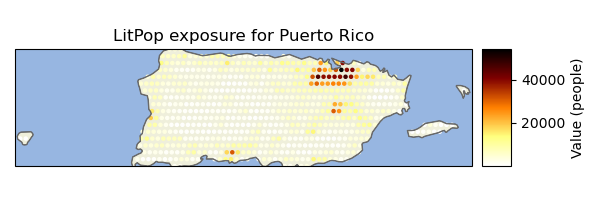

In [24]:
try:
    exposure = load_from_cache('exposure2')
except FileNotFoundError:
    exposure = LitPop.from_population(['Puerto Rico', ], res_arcsec = 120)
    save_to_cache('exposure2', exposure)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(projection=get_projection())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
exposure.plot_scatter(axis=ax, pop_name=False, cmap='afmhot_r', s=5)
ax.set_title('LitPop exposure for Puerto Rico');

If we look at the documentation of the class `Exposure`, we see that we can also specify the `cover` and `deductible` for insurance-related case studies.
1. cover is a boolean taking value 0 or 1 for insured asset and non-insured asset, respectively.
2. deductible is the amount paid by the asset owner out-of-pocket.

## Defining an exposure using custom data

We can also define an exposure using custom data. This might be relevant for instance for an insurance company, where they might want to use data of their customers. 

In Climada we can achieve this as follows. 

```python
import pandas as pd

latitudes = np.array([51.05, 52.08, 52.04, 52.15])
longitudes = np.array([-.6, -.4, .8, .2])
values = np.array([13, 12, 15, 18]) * 1e5

exposure_df = pd.DataFrame(dict(
    latitude=latitudes,
    longitude=longitudes,
    value=values))
```


In [25]:
import pandas as pd

latitudes = np.array([51.05, 52.08, 52.04, 52.15])
longitudes = np.array([-.6, -.4, .8, .2])
values = np.array([13, 12, 15, 18]) * 1e5

exposure_df = pd.DataFrame(dict(
    latitude=latitudes,
    longitude=longitudes,
    value=values))

exposure_df

,latitude,longitude,value
0,51.05,-0.6,1300000.0
1,52.08,-0.4,1200000.0
2,52.04,0.8,1500000.0
3,52.15,0.2,1800000.0


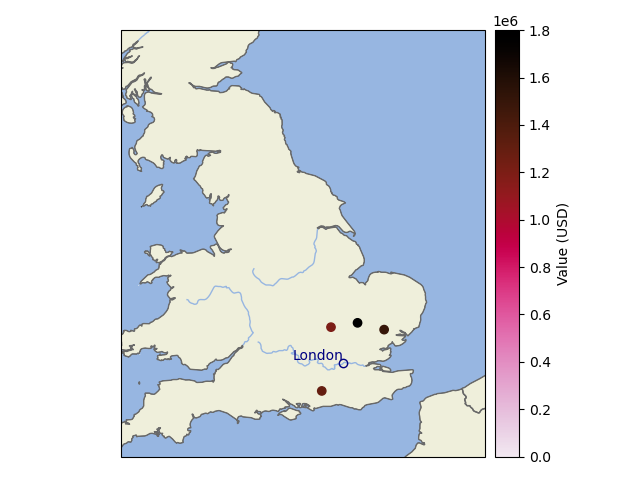

In [26]:
from climada.entity.exposures import Exposures
import cartopy
from utils import get_projection

fig = plt.figure()
ax = fig.add_subplot(projection=get_projection())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)

exposure = Exposures(exposure_df)
exposure.set_geometry_points()
exposure.plot_scatter(axis=ax, vmin=0)
ax.set_extent([-5, 3, 50, 57])


# Impact functions

We saw how we can define:
1. A hazard to express the frequency and intensity of natural disasters
2. An exposure that corresponds to exposed assets

We now need an impact function to put it all together in order to assess the risk.

<div class="alert alert-block alert-success">
As previously mentionned, the impact function maps an intensity level to a damage expressed as a percentage of the value of the exposed asset. As such, an impact function should:
<ul>
    <li>Take values in $[0, 1]$</li>
    <li>Be non-decreasing</li>
</div>

<div class="alert alert-block alert-info">
<b>Exam-type question:</b>

<p>
Among the functions below, which do you think are sensible choices for an impact function? We assume intensities are non-negative.
<ul>
<li>$f(x) = \frac{1}{1 + \exp(-k(x - x_0))}$</li>
<li>$f(x) = -x^2$</li>
<li>$f(x) = \min\left[\left(\frac{x}{x_0}\right) ^ 2, 1\right]$</li>
<li>$f(x) = \max\left[\left(\frac{x}{x_0}\right) ^ 3, 1\right]$</li>
<li>$f(x) = \left(\frac{x}{x_0}\right) ^ 2$</li>
</ul>
</p>

<p>
Choose one of the above impact functions. For an asset of value £$10000$ subject to an intensity of $40$m/s what would be the corresponding impact?
</p>
</div>



The impact for an asset of value $v$ subject to an intensity $x$ is: $v \times f(x)$.

In Climada, an impact function can be defined using the class ImpactFunc [(link to reference)](https://climada-python.readthedocs.io/en/stable/climada/climada.entity.impact_funcs.html#climada.entity.impact_funcs.base.ImpactFunc), 
defined in the base module of the climada.entity.impact_funcs package. Here we use the from_emanuela_usa method of the ImpfTropCyclone class to load a predefined impact function that was calibrated using data from the Emanuel Tropical Cyclone.

For tropical cyclones, we can use a predefined impact function:

```python
from climada.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone

impact_function = ImpfTropCyclone.from_emanuel_usa()

intensities = np.linspace(0, 140)
impacts = impact_function.calc_mdr(intensities)
```

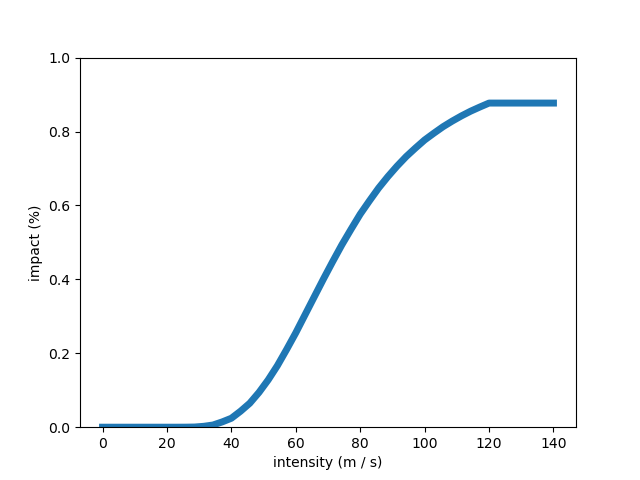

In [27]:
from climada.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone

impact_function = ImpfTropCyclone.from_emanuel_usa()

intensities = np.linspace(0, 140)
impacts = impact_function.calc_mdr(intensities)

plt.figure()
plt.plot(intensities, impacts, linewidth=5)
plt.ylim(0, 1)
plt.xlabel('intensity (m / s)')
plt.ylabel('impact (%)');

On the x-axis, we have the wind intensity in m/s, and on the y-axis, the corresponding impact expressed as a percentage.

Note that you need to *register* our impact function using the following:

```python
imp_fun_set = ImpactFuncSet([impact_function])
exposure.gdf['impf_TC'] = 1
```

In [28]:
imp_fun_set = ImpactFuncSet([impact_function])
exposure.gdf['impf_TC'] = 1

# Putting it all together

```python
from climada.entity import Entity

exposure = LitPop.from_countries(['Puerto Rico', ], res_arcsec = 120)

ent = Entity(
    exposures=exposure,
    impact_func_set=imp_fun_set,
)
```

In [29]:
from climada.entity import Entity

try:
    exposure = load_from_cache('exposure')
except FileNotFoundError:
    exposure = LitPop.from_countries(['Puerto Rico', ], res_arcsec = 120)
    save_to_cache('exposure', exposure)

ent = Entity(
    exposures=exposure,
    impact_func_set=imp_fun_set,
)

We can load the hazard from the previous lecture:

```python
from climada.hazard import Hazard

haz = Hazard.from_hdf5('path_to_file.hdf5')
```

In [30]:
from climada.hazard import Hazard

haz = Hazard.from_hdf5('results/TChazard_hr.hdf5')

And finally use ImpactCalc to define an impact object. From this impact object we can for instance retrieve an exceedance frequency curve:

```python
from climada.engine import ImpactCalc

impact = ImpactCalc(ent.exposures, ent.impact_funcs, haz).impact()

freq_curve = impact.calc_freq_curve()
freq_curve.plot();
```

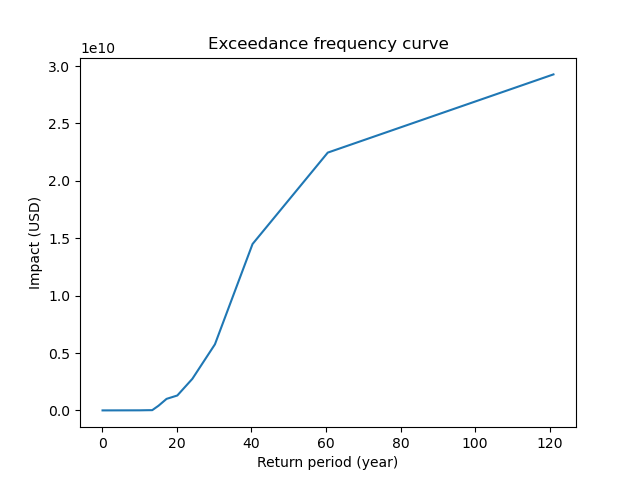

In [31]:
from climada.engine import ImpactCalc

impact = ImpactCalc(ent.exposures, ent.impact_funcs, haz).impact()

freq_curve = impact.calc_freq_curve()
freq_curve.plot();

<div class="alert alert-block alert-info">
    <b>How do we interpret this?</b>
    The same way we interpret return periods for intensities, except that this time we have return periods for impacts.
</div>

## Some other useful metrics

We saw that for an asset with value $v$ subjected to an intensity $x$, the impact is calculated as $v\times f(x)$. This is for a single event however. We can incorportate this approach within our probabilistic framework.

<div class="alert alert-block alert-success">
Let $x_{j,k}$ be the intensity of event $j=1,\ldots, n_j$ at location $k=1, \ldots, n_k$. We can express:
<ul>
    <li>Average Annual Impact at location $k$:
        \begin{equation}
            \frac{\sum_{j=1}^{n_j} v_k f(x_{j,k})}{{n_{\text{years}}}} = v_k \frac{\sum_{j=1}^{n_j} f(x_{j,k})}{{n_{\text{years}}}}.
       \end{equation}
    </li>
    <li>
    Average Annual Impact (summed over all assets):
         \begin{equation}
            \sum_{k=1}^{n_k} v_k \frac{\sum_{j=1}^{n_j} f(x_{j,k})}{{n_{\text{years}}}}.
        \end{equation}
    </li>
</ul>
</div>

<div class="alert alert-block alert-danger">
Note how in the expressions for the Average Annual Impact we divide by the number of years over which the events were recorded.
</div>